In [1]:
!pip install transformers peft torch
!pip install llava

!pip install bitsandbytes
!pip install sentencepiece

!pip install protobuf
!pip install torchvision

!git clone https://github.com/wentaoyuan/RoboPoint.git

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because norma

In [2]:
import sys
sys.path.append('./RoboPoint/')

from robopoint.model.builder import load_pretrained_model
from robopoint.mm_utils import get_model_name_from_path
from robopoint.eval.run_llava import eval_model

from robopoint.conversation import conv_templates, SeparatorStyle
from robopoint.model.builder import load_pretrained_model
from robopoint.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path
from PIL import Image
import requests
import torch
from io import BytesIO

import os
import matplotlib.pyplot as plt
import re

In [3]:
model_path = "wentao-yuan/robopoint-v1-vicuna-v1.5-13b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path),
    #load_8bit=True,
    device="cuda"
)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint at wentao-yuan/robopoint-v1-vicuna-v1.5-13b were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder

In [4]:
"""
# prepare inputs for the model
instruction = "Locate several points within the vacant space positioned in front of the washing machine. Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image."
#instruction = "Describe the image."
text = '<image>' + '\n' + instruction
conv = conv_templates["llava_v1"].copy()
conv.append_message(conv.roles[0], text)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
input_ids = tokenizer_image_token(prompt, tokenizer, -200, return_tensors='pt').unsqueeze(0).cuda()


# prepare image input
image=Image.open("./Images/im_10.jpg").convert('RGB')
image_tensor = process_images([image], image_processor, model.config)[0].unsqueeze(0).half().cuda()

# autoregressively generate text
with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=[image.size],
        do_sample=True,
        temperature=0.2,
        max_new_tokens=1024,
        use_cache=True)

# only get generated tokens; decode them to text
outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print(outputs)
"""

'\n# prepare inputs for the model\ninstruction = "Locate several points within the vacant space positioned in front of the washing machine. Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image."\n#instruction = "Describe the image."\ntext = \'<image>\' + \'\n\' + instruction\nconv = conv_templates["llava_v1"].copy()\nconv.append_message(conv.roles[0], text)\nconv.append_message(conv.roles[1], None)\nprompt = conv.get_prompt()\ninput_ids = tokenizer_image_token(prompt, tokenizer, -200, return_tensors=\'pt\').unsqueeze(0).cuda()\n\n\n# prepare image input\nimage=Image.open("./Images/im_10.jpg").convert(\'RGB\')\nimage_tensor = process_images([image], image_processor, model.config)[0].unsqueeze(0).half().cuda()\n\n# autoregressively generate text\nwith to

In [5]:
"""
Gibt zwei Arrays zurück, die jeweils die tasks (strings) bzw die Bilder enthalten.
Geht die Folder durch und liest die task aus lang.txt und das bild aus im_0
"""
def extract_tasks_and_images(path_to_directory):
    tasks = []
    images = []

    for experiment in os.listdir(path_to_directory):
        if experiment.startswith("."):
            continue
        subdir_path = os.path.join(path_to_directory, experiment)
        task_file_path = os.path.join(subdir_path, "lang.txt")

        # Get Task
        with open(task_file_path, "r") as lang_file:
            task = lang_file.read()
            tasks.append(task)

        # Get image
        for file in os.listdir(subdir_path):
                    if file.startswith("im_") and file.endswith((".png", ".jpg", ".jpeg")):
                        image_path = os.path.join(subdir_path, file)
                        image = Image.open(image_path)
                        images.append(image)

    return tasks, images  

In [6]:
"""
Scaled die Koordinaten auf die Größe des images und gibt diese zurück
"""
def scale_coordinates(coordinates, image_width, image_height):
    scaled_coordinates = []
    for x, y in coordinates:
        # Scale coordinates to the image size
        scaled_x = x * image_width
        scaled_y = y * image_height
        scaled_coordinates.append((int(scaled_x), int(scaled_y)))
    return scaled_coordinates

def extract_coordinates(coord_string):
    # Find pattern: (x, y)
    pattern = r'\((\d+\.?\d*),\s*(\d+\.?\d*)\)'
    matches = re.findall(pattern, coord_string)
    
    coordinates = [(float(x), float(y)) for x, y in matches]
    return coordinates

def visualize_points_on_image(image, labels, list_of_coordinates):
    plt.imshow(image, alpha=1)
    image_width, image_height = image.size

    for label, coordinates in zip(labels, list_of_coordinates):
        # Extract and scale coordinates
        scaled_coordinates = scale_coordinates(coordinates, image_width, image_height)
        
        # Extract and plot the points
        x_coords = [x for x, y in scaled_coordinates]
        y_coords = [y for x, y in scaled_coordinates]
        plt.scatter(x_coords, y_coords, marker='o', label=label)
        
        # Annotate each point
        #for i, (x, y) in enumerate(scaled_coordinates):
        #    plt.text(x, y, f'{label}: {i+1}', color='black', fontsize=9, ha='right', va='bottom')
    
    # Add labels and show the plot
    plt.title("Coordinates on Image")
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

In [7]:
PROMPT_OUTPUT_FORMAT="Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image."
PROMPT_TASK="Locate several points within the vacant space for the following task: "

def generate_prompt(task, prompt_task=PROMPT_TASK, prompt_output_format=PROMPT_OUTPUT_FORMAT):
    text = '<image>' + '\n' + prompt_task + task + "." + prompt_output_format
    conv = conv_templates["llava_v1"].copy()
    conv.append_message(conv.roles[0], text)
    conv.append_message(conv.roles[1], None)
    return conv.get_prompt()
    

"""
Führt die inference auf dem image aus
"""
def do_inference_on_image(image, prompt, temperature=0.2):
    # prepare inputs for the model
    input_ids = tokenizer_image_token(prompt, tokenizer, -200, return_tensors='pt').unsqueeze(0).cuda()
    
    # prepare image input
    image_tensor = process_images([image], image_processor, model.config)[0].unsqueeze(0).half().cuda()
    
    # autoregressively generate text
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            #image_sizes=[image.size],
            do_sample=True,
            temperature=temperature,
            max_new_tokens=1024,
            use_cache=False)
    
    # only get generated tokens; decode them to text
    output = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
    #torch.cuda.empty_cache()
    
    return output

Task: 1
Move the can from the top left of the burner to the bottom left of the burner

Run: 1 - Output: [(0.244, 0.444), (0.228, 0.446), (0.261, 0.446)]
Run: 2 - Output: [(0.286, 0.575), (0.269, 0.573), (0.248, 0.573), (0.231, 0.573)]
Run: 3 - Output: [(0.255, 0.540), (0.239, 0.533), (0.270, 0.537)]
Run: 4 - Output: [(0.227, 0.448), (0.242, 0.442), (0.258, 0.444), (0.211, 0.446)]
Run: 5 - Output: [(0.250, 0.458), (0.270, 0.458), (0.286, 0.456), (0.234, 0.456)]


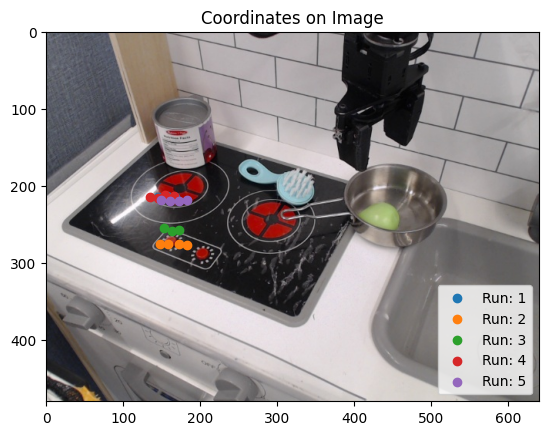

Task: 2
pick up red srewdriver

Run: 1 - Output: [(0.505, 0.571), (0.486, 0.571), (0.520, 0.575)]
Run: 2 - Output: [(0.511, 0.681), (0.536, 0.690), (0.552, 0.685), (0.527, 0.671)]
Run: 3 - Output: [(0.519, 0.617), (0.534, 0.613), (0.503, 0.615)]
Run: 4 - Output: [(0.503, 0.656), (0.520, 0.665), (0.537, 0.656), (0.553, 0.654)]
Run: 5 - Output: [(0.502, 0.656), (0.484, 0.660), (0.519, 0.652)]


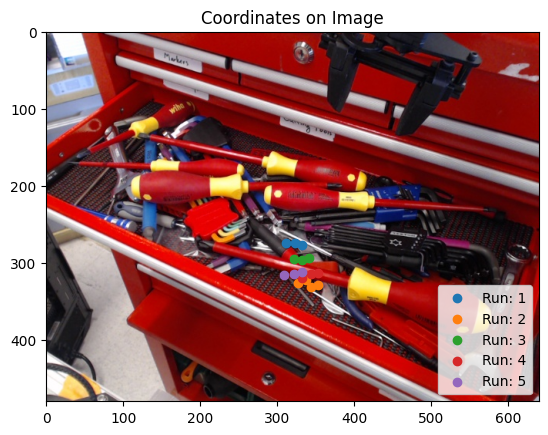

Task: 3
take the eggplant and put it between the two right burners

Run: 1 - Output: [(0.466, 0.502), (0.481, 0.506), (0.448, 0.504), (0.497, 0.508)]
Run: 2 - Output: [(0.497, 0.523), (0.514, 0.523), (0.477, 0.519), (0.530, 0.521)]
Run: 3 - Output: [(0.466, 0.506), (0.483, 0.502), (0.450, 0.515)]
Run: 4 - Output: [(0.439, 0.504), (0.455, 0.500), (0.420, 0.504)]
Run: 5 - Output: [(0.452, 0.502), (0.434, 0.500), (0.469, 0.500)]


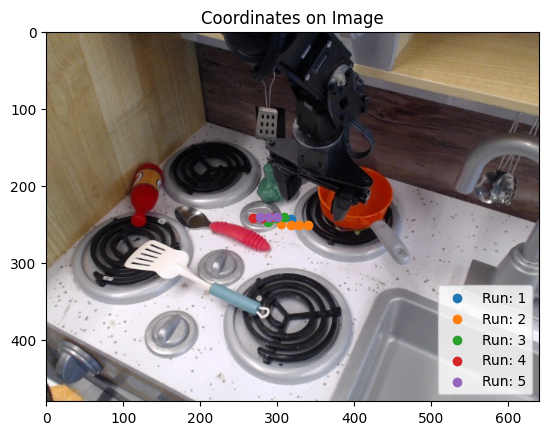

Task: 4
move arch on the table and place it on top of another arch

Run: 1 - Output: [(0.472, 0.623), (0.455, 0.623), (0.487, 0.621)]
Run: 2 - Output: [(0.484, 0.704), (0.464, 0.704), (0.445, 0.706), (0.472, 0.685)]
Run: 3 - Output: [(0.402, 0.748), (0.419, 0.731), (0.434, 0.729), (0.450, 0.727), (0.417, 0.752)]
Run: 4 - Output: [(0.439, 0.702), (0.414, 0.698), (0.455, 0.700)]
Run: 5 - Output: [(0.569, 0.679), (0.552, 0.673), (0.536, 0.675), (0.584, 0.677)]


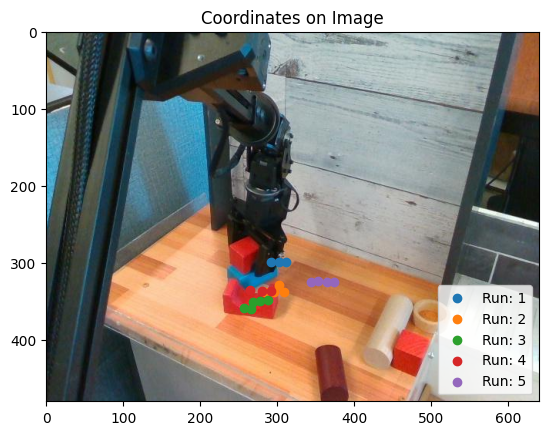

Task: 5
take sushi out of pan

Run: 1 - Output: [(0.303, 0.504), (0.287, 0.496), (0.322, 0.502), (0.272, 0.494)]
Run: 2 - Output: [(0.352, 0.429), (0.333, 0.438), (0.319, 0.425), (0.303, 0.427)]
Run: 3 - Output: [(0.344, 0.502), (0.372, 0.498), (0.356, 0.487), (0.328, 0.504)]
Run: 4 - Output: [(0.389, 0.450), (0.373, 0.446), (0.348, 0.442), (0.333, 0.450), (0.366, 0.427), (0.355, 0.463), (0.383, 0.425)]
Run: 5 - Output: [(0.256, 0.519), (0.281, 0.517), (0.241, 0.515), (0.297, 0.512)]


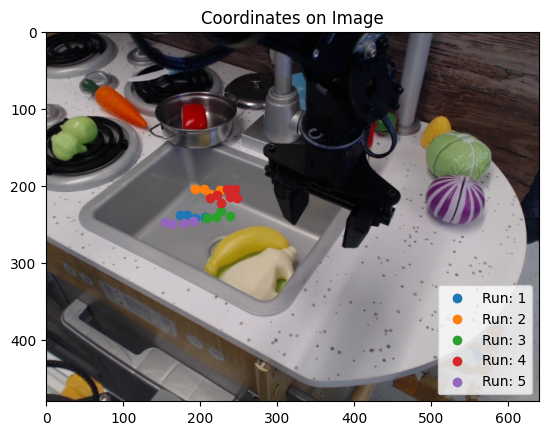

Task: 6
pick up glass cup

Run: 1 - Output: [(0.341, 0.402), (0.323, 0.402), (0.356, 0.404)]
Run: 2 - Output: [(0.383, 0.433), (0.400, 0.433), (0.367, 0.431)]
Run: 3 - Output: [(0.377, 0.637), (0.397, 0.637), (0.359, 0.633), (0.414, 0.635)]
Run: 4 - Output: [(0.588, 0.546), (0.572, 0.554), (0.552, 0.560), (0.536, 0.556), (0.567, 0.533)]
Run: 5 - Output: [(0.372, 0.369), (0.353, 0.373), (0.388, 0.367)]


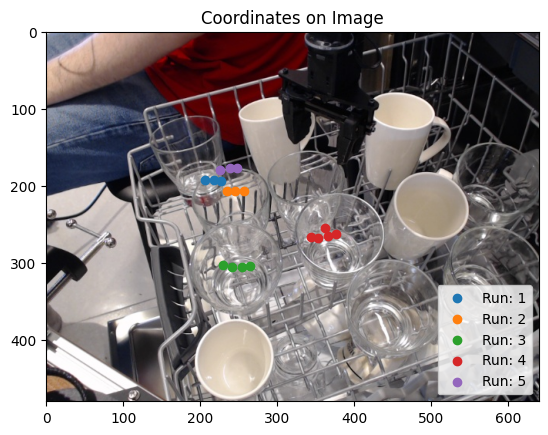

Task: 7
open low fridge

Run: 1 - Output: [(0.444, 0.171), (0.483, 0.173), (0.466, 0.171), (0.428, 0.167)]
Run: 2 - Output: [(0.433, 0.183), (0.452, 0.179), (0.470, 0.179), (0.417, 0.181)]
Run: 3 - Output: [(0.498, 0.173), (0.483, 0.175), (0.467, 0.171), (0.514, 0.171)]
Run: 4 - Output: [(0.481, 0.188), (0.461, 0.190), (0.497, 0.190)]
Run: 5 - Output: [(0.464, 0.150), (0.441, 0.144), (0.481, 0.150), (0.425, 0.146)]


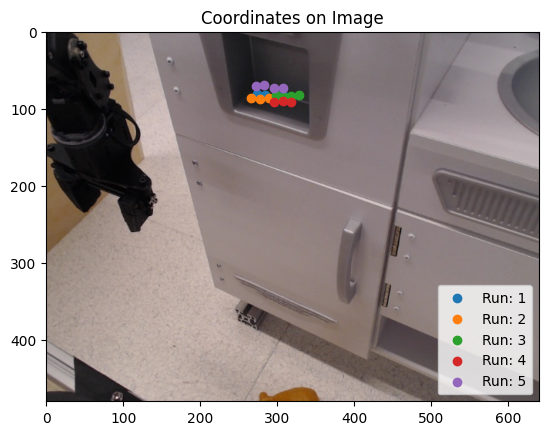

Task: 8
Place the pot to the right of the blue fork.
Move silver pot to lower right corner of the table.

Run: 1 - Output: [(0.588, 0.552), (0.619, 0.517), (0.603, 0.537), (0.634, 0.510), (0.650, 0.512), (0.586, 0.529), (0.619, 0.540), (0.603, 0.515)]
Run: 2 - Output: [(0.592, 0.577), (0.539, 0.588), (0.575, 0.571), (0.555, 0.579), (0.523, 0.590)]
Run: 3 - Output: [(0.480, 0.569), (0.489, 0.548), (0.458, 0.556), (0.505, 0.556), (0.473, 0.548), (0.442, 0.554)]
Run: 4 - Output: [(0.558, 0.583), (0.592, 0.596), (0.577, 0.588), (0.537, 0.585), (0.519, 0.581), (0.575, 0.610), (0.559, 0.604)]
Run: 5 - Output: [(0.573, 0.552), (0.528, 0.554), (0.545, 0.558), (0.591, 0.552), (0.508, 0.554), (0.559, 0.542)]


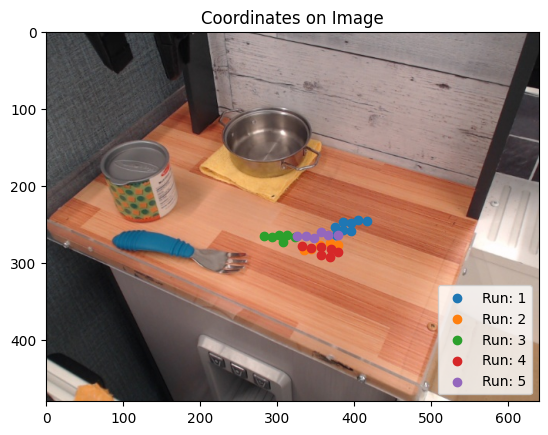

In [15]:
#tasks, images = extract_tasks_and_images("./data")
tasks, images = extract_tasks_and_images("./xai-praktikum/molmo/data2")

#for i in range(len(tasks)):
for i in range(len(tasks)):   
    print(f"Task: {i + 1}")
    image = images[i]
    task = tasks[i]

    labels = []
    coordinate_list = []
    print(tasks[i])

    
    for j in range(5):
        labels.append(f"Run: {j + 1}")

        prompt = generate_prompt(task)
        output = do_inference_on_image(image, prompt, 0.2)
        coordinate_list.append(extract_coordinates(output))
    
        print(f"Run: {j + 1} - Output: {output}")

    visualize_points_on_image(image, labels, coordinate_list)

    



Task: 1
Move the can from the top left of the burner to the bottom left of the burner

Prompt: 1 - Output: [(0.223, 0.369), (0.255, 0.379)]
Prompt: 2 - Output: [(0.275, 0.475), (0.289, 0.487)]
Prompt: 3 - Output: [(0.267, 0.460), (0.220, 0.458), (0.236, 0.454), (0.252, 0.465)]
Prompt: 4 - Output: [(0.295, 0.290), (0.314, 0.279), (0.280, 0.287)]
Prompt: 5 - Output: [(0.294, 0.515), (0.311, 0.510), (0.330, 0.512)]


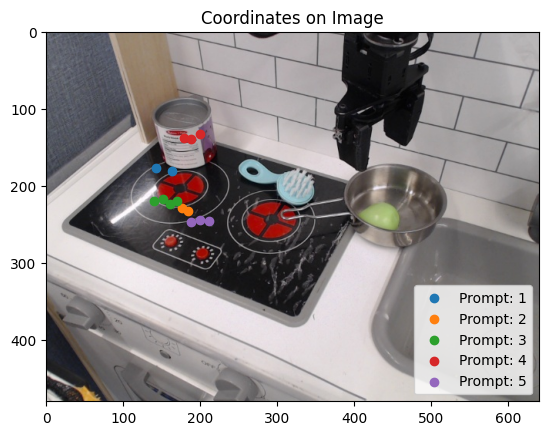

In [16]:
#tasks, images = extract_tasks_and_images("./data")
tasks, images = extract_tasks_and_images("./xai-praktikum/molmo/data2")

prompts = [
    "Locate several points within the vacant space for the following task: Move the can from the top left of the burner to the bottom left of the burner",
    "Locate several points within the vacant space of the bottom left of the burner",
    "Pinpoint several points within the vacant space of the top left of the burner",
    "Pinpoint several points within the vacant space around the can in the top left of the burner",
    "Locate several points within the free space between the two burners"
]

#for i in range(len(tasks)):
for i in [0]:   
    print(f"Task: {i + 1}")
    image = images[i]
    task = tasks[i]

    labels = []
    coordinate_list = []
    print(tasks[i])
    
    for j in range(len(prompts)):
        labels.append(f"Prompt: {j + 1}")

        prompt = generate_prompt("", prompts[j])
        output = do_inference_on_image(image, prompt, 0.5)
        coordinate_list.append(extract_coordinates(output))
    
        print(f"Prompt: {j + 1} - Output: {output}")

    visualize_points_on_image(image, labels, coordinate_list)

    



In [11]:
import torch
import torch.nn.functional as F

def do_inference_with_logits(image, prompt, temperature=0.2):
    # Prepare text input
    input_ids = tokenizer_image_token(prompt, tokenizer, -200, return_tensors='pt').unsqueeze(0).cuda()

    # Prepare image input
    image_tensor = process_images([image], image_processor, model.config)[0].unsqueeze(0).half().cuda()

    # autoregressively generate text
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            images=image_tensor,
            #image_sizes=[image.size],
            do_sample=True,
            temperature=temperature,
            max_new_tokens=1024,
            output_scores=True,
            output_logits=True,
            return_dict_in_generate=True,
            use_cache=True)

    # Extract generated IDs and scores
    generated_ids = outputs.sequences
    
    logits_per_step = outputs.logits  # List of logits at each generation step
    print(f"Logits: {logits_per_step}\n")

    scores = outputs.scores
    #print(f"Scores: {scores.shape}\n")
    
    # Extract only generated tokens (excluding prompt tokens)
    generated_tokens = generated_ids[:, input_ids.shape[-1]:]
    print(f"Generated Tokens Shape: {generated_tokens.shape}\n")

    # Decode text output
    output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print(f"Decoded Output: {output}\n")

    # Calculate log-probabilities
    log_probs = []
    for i, logits in enumerate(logits_per_step):
        # Apply log-softmax to logits
        log_prob = F.log_softmax(logits, dim=-1)

        # Extract probability of generated token
        if i < generated_tokens.shape[-1]:  # Avoid out-of-bounds indexing
            token_id = generated_tokens[:, i].unsqueeze(-1)
            token_log_prob = log_prob.gather(1, token_id).squeeze(-1)
            log_probs.append(token_log_prob)

            print(f"Step {i}: Token ID: {token_id.squeeze().item()}, Log-Probability: {token_log_prob.squeeze().item()}\n")

    # Average log-likelihood
    avg_log_likelihood = torch.stack(log_probs).mean().item()
    print(f"Average Log-Likelihood: {avg_log_likelihood}\n")

    return output